**Key tasks:**

1. Use this data to train a model that, given details for any loan described above, will predict the probability of default.

2. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

loans_df = pd.read_csv("/content/Task 3 and 4_Loan_Data.csv")
loans_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [2]:
print(loans_df.dtypes)

customer_id                   int64
credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object


In [3]:
loans_df['default'].value_counts()

,count
default,
0,8149
1,1851


In [4]:
!pip install sns

  Preparing metadata (setup.py) ... done
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2639 sha256=f6088be425c1452ea4a6bca616107f645b276992a89ea59594fe551fa1e3f5ac
  Stored in directory: /root/.cache/pip/wheels/7c/e1/f6/7f1e51e342bccba75ac6cfae60918407acaa6999034889d25e
Successfully built sns


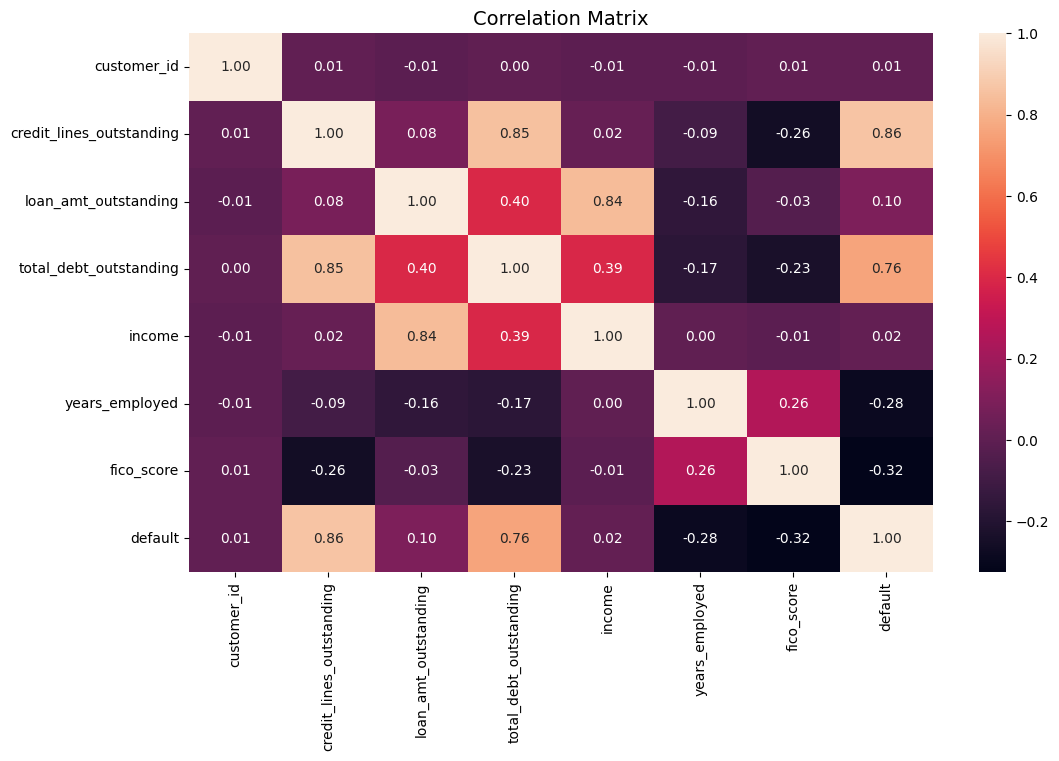

In [5]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,7))
corr = loans_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")
ax.set_title("Correlation Matrix", fontsize=14)
plt.show()

In [6]:
print(loans_df.corr()['default'].sort_values(ascending=False))

default                     1.000000
credit_lines_outstanding    0.862815
total_debt_outstanding      0.758868
loan_amt_outstanding        0.098978
income                      0.016309
customer_id                 0.006927
years_employed             -0.284506
fico_score                 -0.324515
Name: default, dtype: float64


<ipython-input-7-518983bd0b55>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  q.set_xticklabels(q.get_xticklabels())


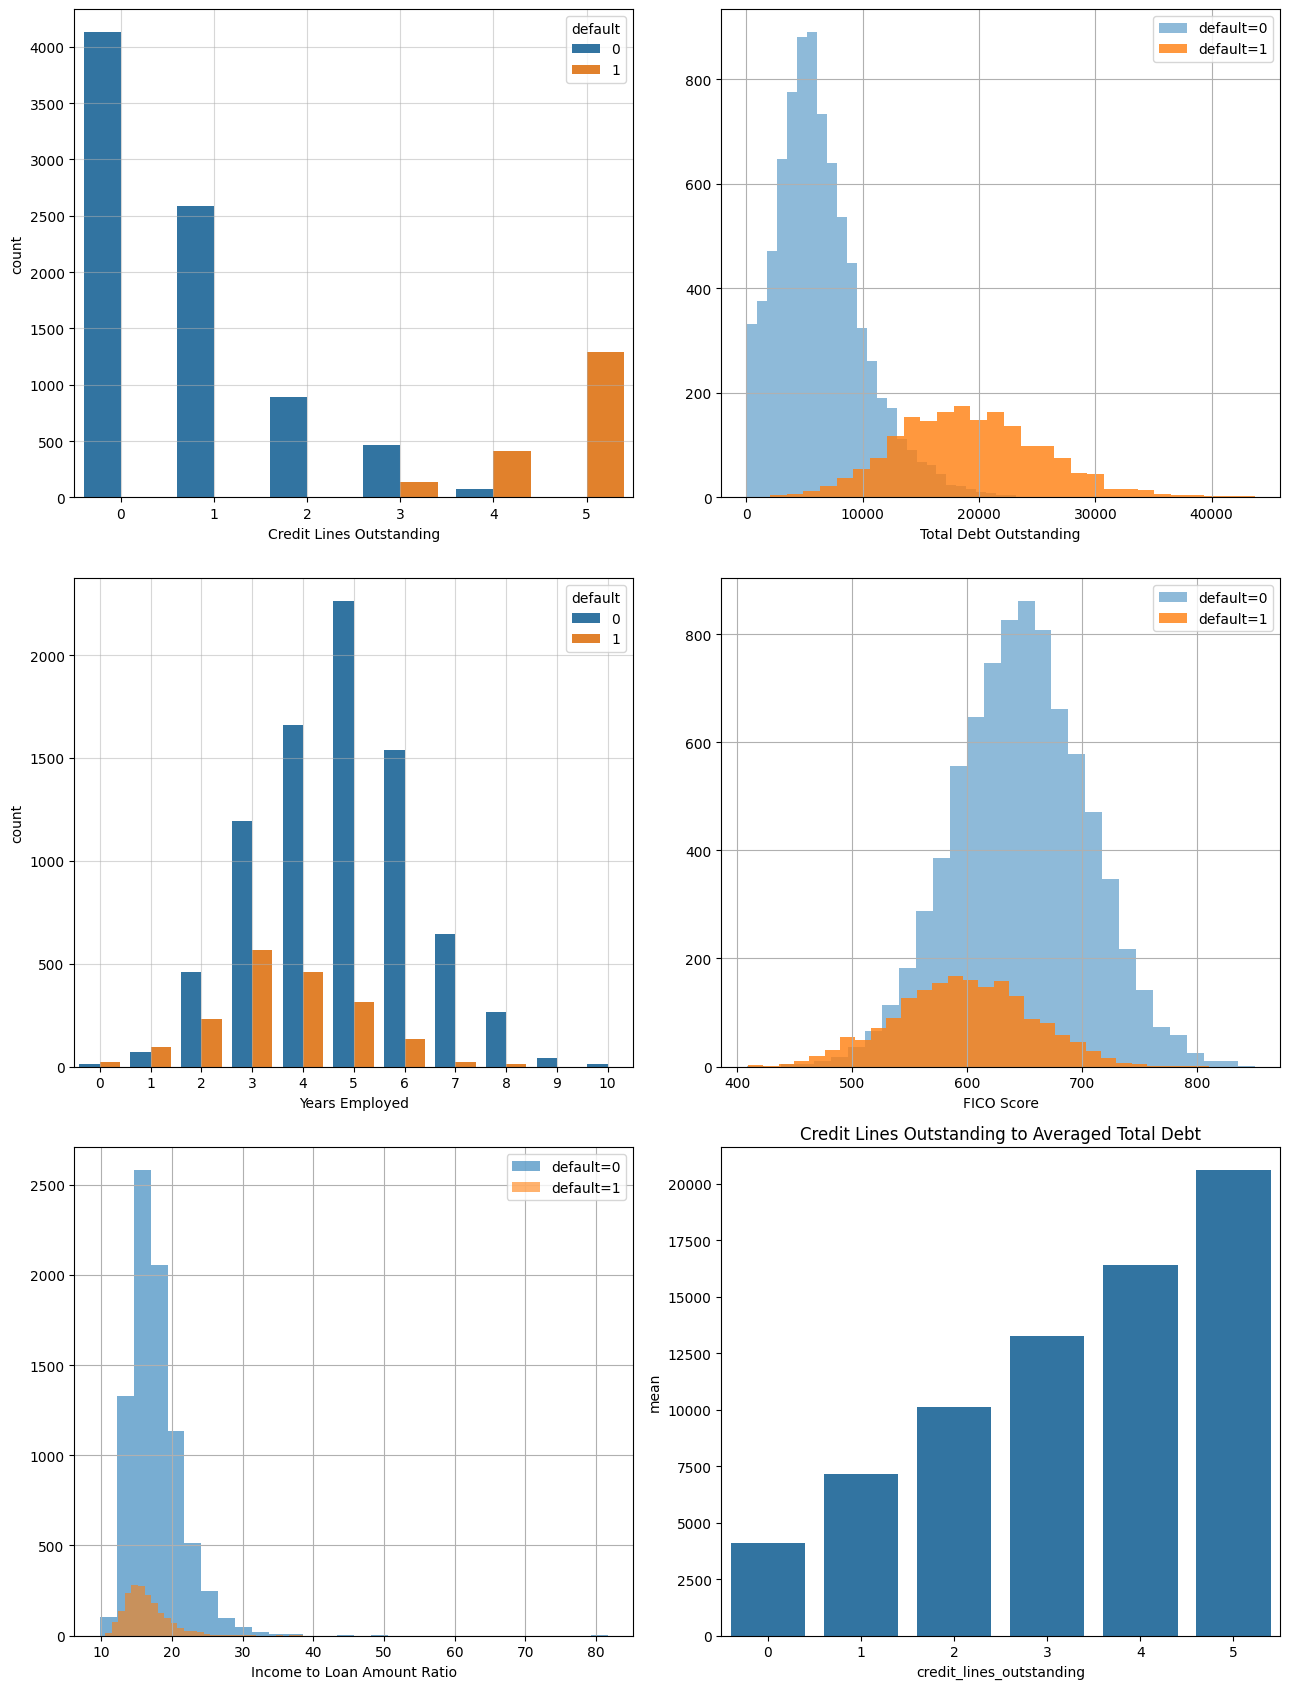

In [7]:
# Exploratary Data Analysis

plt.figure(figsize=(13, 17))

plt.subplot(3, 2, 1)
sns.countplot(x=loans_df['credit_lines_outstanding'],hue=loans_df['default'])
plt.grid(alpha=0.5)
plt.xlabel('Credit Lines Outstanding')

plt.subplot(3, 2, 2)
loans_df[loans_df['default']==0]['total_debt_outstanding'].hist(bins=30, alpha=0.5, label='default=0')
loans_df[loans_df['default']==1]['total_debt_outstanding'].hist(bins=30, alpha=0.8, label='default=1')
plt.legend()
plt.xlabel('Total Debt Outstanding')

plt.subplot(3, 2, 3)
sns.countplot(x=loans_df['years_employed'],hue=loans_df['default'])
plt.grid(alpha=0.5)
plt.xlabel('Years Employed')

plt.subplot(3, 2, 4)
loans_df[loans_df['default']==0]['fico_score'].hist(bins=30, alpha=0.5, label='default=0')
loans_df[loans_df['default']==1]['fico_score'].hist(bins=30, alpha=0.8, label='default=1')
plt.legend()
plt.xlabel('FICO Score')


loans_df['ratio_income_loan_amt'] = loans_df['income']/loans_df['loan_amt_outstanding']

plt.subplot(3, 2, 5)
loans_df[loans_df['default']==0]['ratio_income_loan_amt'].hist(bins=30,alpha=0.6,label='default=0')
loans_df[loans_df['default']==1]['ratio_income_loan_amt'].hist(bins=30,alpha=0.6,label='default=1')
plt.legend()
plt.xlabel('Income to Loan Amount Ratio')

plt.subplot(3, 2, 6)
df = loans_df.groupby(['credit_lines_outstanding'])['total_debt_outstanding'].mean().reset_index(name='mean').sort_values('credit_lines_outstanding',ascending=True)
q = sns.barplot(x="credit_lines_outstanding", y="mean", data=df)
q.set_xticklabels(q.get_xticklabels())
plt.title('Credit Lines Outstanding to Averaged Total Debt')

plt.tight_layout()
plt.show()

## **Construction of Predictive Modelling**

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix

def load_data(path):
    df = pd.read_csv(path)
    features = ['total_debt_outstanding', 'credit_lines_outstanding', 'years_employed', 'fico_score']
    target = 'default'
    return df[features], df[target]

X, y = load_data("/content/Task 3 and 4_Loan_Data.csv")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\nEvaluation Metrics ({model_name}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    return model

# Logistic Regression
lr_model = train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression", X_train_scaled, X_test_scaled, y_train, y_test)

# Decision Tree
dt_model = train_and_evaluate(DecisionTreeClassifier(random_state=42), "Decision Tree", X_train, X_test, y_train, y_test)

# Neural Network
nn_model = train_and_evaluate(
    MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42), "Neural Network (MLP)", X_train_scaled, X_test_scaled, y_train, y_test)



Evaluation Metrics (Logistic Regression):
Accuracy: 0.9944
F1 Score: 0.9840
Recall: 0.9773
ROC AUC Score: 0.9999

Evaluation Metrics (Decision Tree):
Accuracy: 0.9932
F1 Score: 0.9807
Recall: 0.9795
ROC AUC Score: 0.9878

Evaluation Metrics (Neural Network (MLP)):
Accuracy: 0.9940
F1 Score: 0.9829
Recall: 0.9795
ROC AUC Score: 0.9998


**Accuracy:** Out of every 1000 instances, it's getting about 994 correct.

**F1 Score:** The harmonic mean of precision and recall. It's not only good at finding the positive instances (high recall) but also doesn't misclassify negative instances as positive very often (high precision).

**Recall:** True Positive Rate. True Positives / (True Positives + False Negatives)


**ROC AUC Score:** ROC stands for Receiver Operating Characteristic, and AUC stands for Area Under the Curve. There's a very high probability that if you randomly picked one positive and one negative instance, your model would correctly rank the positive one higher.

In [9]:
def calculate_expected_loss(parameters, model, scaler=None, recovery_rate=0.1):
    df = pd.DataFrame([parameters])

    if scaler:
        df = scaler.transform(df)

    prob_default = model.predict_proba(df)[0][1]
    expected_loss = prob_default * (1 - recovery_rate)
    return expected_loss

sample_input = {
    'total_debt_outstanding': 20_000,
    'credit_lines_outstanding': 4,
    'years_employed': 6,
    'fico_score': 600
}

el_lr = calculate_expected_loss(sample_input, lr_model, scaler)
el_dt = calculate_expected_loss(sample_input, dt_model)
el_nn = calculate_expected_loss(sample_input, nn_model, scaler)

print(f"Expected Loss (Logistic Regression): {el_lr*100:.3f}%")
print(f"Expected Loss (Decision Tree): {el_dt*100:.3f}%")
print(f"Expected Loss (Neural Network): {el_nn*100:.3f}%")

Expected Loss (Logistic Regression): 73.557%
Expected Loss (Decision Tree): 90.000%
Expected Loss (Neural Network): 89.460%
